<a href="https://colab.research.google.com/github/dmitriy-iliyov/data-science/blob/main/neural-network/lstm/notebook/lab_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
datasets_dir = '/content/drive/MyDrive/data/reviews'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

path = "yelp-dataset/yelp-dataset"

dir_name = path.split('/')[1]
current_dir_path = os.path.join(datasets_dir, dir_name)

os.makedirs(current_dir_path, exist_ok=True)

!kaggle datasets download -d {path} -p {current_dir_path}

zip_file_path = os.path.join(current_dir_path, f"{dir_name}.zip")
!unzip -q {zip_file_path} -d {current_dir_path}

os.remove(zip_file_path)

In [2]:
import json

def read_data(d):
  reviews = []
  stars = []
  with open(datasets_dir + '/yelp-dataset/yelp_academic_dataset_review.json', encoding='utf-8') as file:
    count = 0
    for line in file:
      jsoned_line = json.loads(line)
      reviews.append(jsoned_line['text'])
      stars.append(jsoned_line['stars'])
      count += 1
      if count >= d:
        break
  return reviews, stars


In [3]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk import *
from nltk.corpus import stopwords


nltk.download('stopwords')


def _start_pre_processing(doc):
    doc = re.sub(r'http[s]?://\S+|www\.\S+', '', doc)
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    wpt = WordPunctTokenizer()
    tokens = wpt.tokenize(doc)
    custom_stopwords = set(stopwords.words('english')) - {
    'not', 'very', 'never', 'no', 'nothing', 'more', 'less', 'good', 'great', 'happy',
    'excellent', 'amazing', 'bad', 'horrible', 'sad', 'angry', 'worse', 'could', 'should',
    'would', 'might', 'may', 'absolutely', 'completely', 'totally', 'think', 'opinion'
    }
    filtered_tokens = [token for token in tokens if token not in custom_stopwords]
    doc = ' '.join(filtered_tokens)
    return doc


def _str_pre_processing(_str):
    sentences = _str.split('.')
    prepared_corpus = [_start_pre_processing(sentence) for sentence in sentences]
    prepared_corpus = ' '.join(list(filter(None, prepared_corpus)))
    return prepared_corpus


def do_pre_processing(doc):
    if isinstance(doc, str):
        return _str_pre_processing(doc)
    else:
        print("ERROR:   TextPreProcessor can't prepare this type of data.")
        return None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import resample
from sklearn.utils import shuffle



def prepare_reviews(reviews, max_text_len, pre_processing):
    num_words = 10000
    if(pre_processing):
        reviews = [do_pre_processing(review) for review in reviews]

    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(reviews)
    reviews = tokenizer.texts_to_sequences(reviews)
    print(f'rewiev example: {reviews[0]}')

    reviews = pad_sequences(reviews, maxlen=max_text_len)

    return reviews, num_words


def prepare_stars(stars):
    stars = np.array(stars)
    stars = stars.reshape(-1, 1)
    encoder = OneHotEncoder()
    stars = encoder.fit_transform(stars).toarray()
    stars = np.array(stars).astype(int)
    print(f'star example: {stars[0]}')
    return stars


def downsampling(reviews, stars):
    reviews = np.array(reviews)
    stars = np.array(stars).astype(int)

    class_counts = np.bincount(stars)[1:]
    min_count = np.min(class_counts)
    print(f'class counts before downsampling: {class_counts}')

    balanced_reviews = []
    balanced_stars = []

    for star in np.unique(stars):
      class_reviews = reviews[stars == star]
      class_stars = stars[stars == star]

      if len(class_reviews) > min_count:
          class_reviews_resampled, class_stars_resampled = resample(class_reviews,
                                                                    class_stars,
                                                                    replace=False,
                                                                    n_samples=min_count,
                                                                    random_state=42)
          balanced_reviews.extend(class_reviews_resampled)
          balanced_stars.extend(class_stars_resampled)
      else:
          balanced_reviews.extend(class_reviews)
          balanced_stars.extend(class_stars)

    balanced_reviews = np.array(balanced_reviews)
    balanced_stars = np.array(balanced_stars)

    class_counts = np.bincount(balanced_stars)[1:]
    print(f'class counts after downsampling: {class_counts}')

    balanced_reviews, balanced_stars = shuffle(balanced_reviews, balanced_stars, random_state=42)

    return balanced_reviews, balanced_stars


def prepare_data(d, k, max_text_len, pre_processing = True):

    reviews, stars = read_data(d)

    reviews, stars = downsampling(reviews, stars)

    reviews, word_count = prepare_reviews(reviews, max_text_len, pre_processing)
    print(f'reviews count: {len(reviews)}')

    stars = prepare_stars(stars)


    index = int(k * len(reviews))
    train_data = reviews[:index]
    train_answers = stars[:index]
    test_data = reviews[index:]
    test_answers = stars[index:]

    return train_data, train_answers, test_data, test_answers, word_count


In [5]:
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout
from matplotlib import pyplot as plt


class KerasLSTM:

    def __init__(self, word_count, max_length):
        self._model = Sequential([
            Input(shape=(max_length,)),
            Embedding(input_dim=word_count + 1, output_dim=128, input_length=max_length),
            LSTM(128, activation='tanh', return_sequences=True),
            #Dropout(0.2),
            LSTM(64, activation='tanh', return_sequences=False),
            # Dropout(0.2),
            Dense(5, activation='softmax')
        ])
        self._model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def summary(self):
        self._model.summary()

    def fit(self, train_data, train_answers, validation_split=0.1, epochs=100, batch_size=256):
        start_time = time.time()
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=1,
            restore_best_weights=True
        )
        history = self._model.fit(
            train_data, train_answers,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stopping]
        )
        execution_time = time.time() - start_time
        print(f"Training completed in {execution_time:.2f} seconds.")
        self.plot_history(history, execution_time)
        self.save()
        return history, execution_time

    def evaluate(self, test_data, test_answers):
        test_loss, test_accuracy = self._model.evaluate(test_data, test_answers, verbose=1)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
        return test_loss, test_accuracy

    def predict(self, sequence):
        return self._model.predict(sequence)

    def save(self, path='/content/drive/MyDrive/main/languages/Python/neural_network/labs/lab_7/model/lstm_model.keras'):
        self._model.save(path)

    @staticmethod
    def plot_history(history, execution_time):
        epochs = len(history.history['loss'])
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy (Execution Time: {execution_time:.2f} seconds)')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()



class counts before downsampling: [21922 16116 22648 50383 88931]
class counts after downsampling: [16116 16116 16116 16116 16116]
rewiev example: [251, 1749, 4, 245, 1, 1288, 7368, 1197, 1749, 1588, 598, 766, 7262, 986, 738, 9170, 999, 1813, 67, 155, 9, 10, 4, 7, 345, 104, 491, 4312, 162]
reviews count: 80580
star example: [0 1 0 0 0]
Vocabulary length: 10000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 200, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461,445 (5.57 MB)

 Trainable params: 1,461,445 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.4313 - loss: 1.2606 - val_accuracy: 0.5666 - val_loss: 0.9788
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6048 - loss: 0.9037 - val_accuracy: 0.5866 - val_loss: 0.9531
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.6373 - loss: 0.8403 - val_accuracy: 0.5823 - val_loss: 0.9671
Training completed in 29.74 seconds.


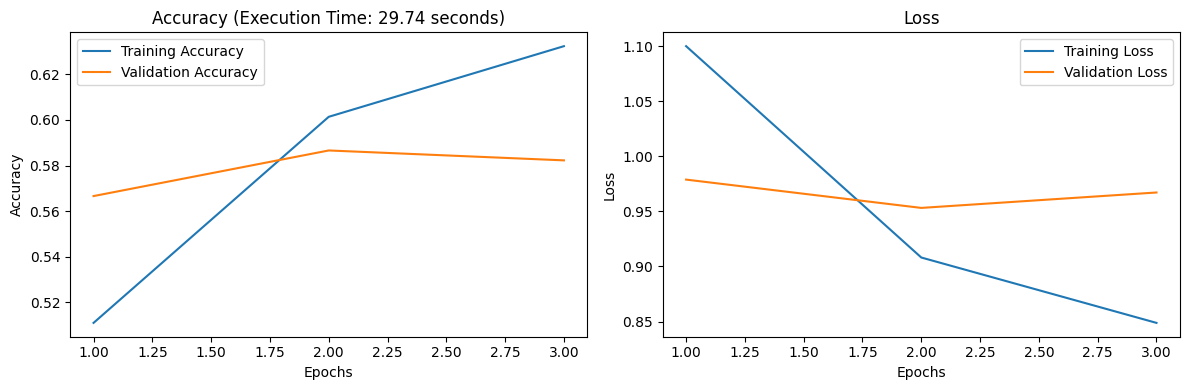

503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5754 - loss: 0.9672
Test Loss: 0.9607954621315002, Test Accuracy: 0.5822564363479614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
real stars: 2; predicted: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
real stars: 3; predicted: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
real stars: 2; predicted: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
real stars: 2; predicted: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
real stars: 3; predicted: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
real stars: 2; predicted: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
real stars: 4; predicted: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
real stars: 4; predicted: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
real stars: 3; predicted: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
real stars: 5; predicted: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
real stars: 5; predicted: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
real stars: 2; predicted: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
real stars: 3; predicted: 3
1

In [7]:
with tf.device('/GPU:0'):
  reviews_count = 200000
  max_length = 200
  train_data, train_answers, test_data, test_answers, word_count = prepare_data(reviews_count, 0.8, max_length)

  print(f'Vocabulary length: {word_count}')

  lstm = KerasLSTM(word_count, max_length)
  lstm.summary()

  lstm.fit(train_data, train_answers, epochs=20)

  count = 20

  predicting_data = test_data[:count].copy()
  predicting_answers = test_answers[:count].copy().tolist()
  test_data = test_data[count:]
  test_answers = test_answers[count:]

  lstm.evaluate(test_data, test_answers)

  for i, data in enumerate(predicting_data):
      data = data.reshape(1, -1)
      predicted_vec = lstm.predict(data)[0].tolist()
      max_val_in_vec = max(predicted_vec)
      predicted_val_index = predicted_vec.index(max_val_in_vec)
      predicterd_val = predicted_val_index+1
      print(f"real stars: {(predicting_answers[i].index(1)) + 1}; predicted: {predicterd_val}")